In [1]:
%matplotlib inline
import os 
import numpy as np
from numpy import mean, std
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from scipy.stats import ttest_rel, ttest_ind, mannwhitneyu, wilcoxon, spearmanr,pearsonr, fisher_exact,kstest
from scipy.stats import ks_2samp, kstest, anderson, anderson_ksamp, levene
from statsmodels.sandbox.stats.multicomp import fdrcorrection0
from sklearn import preprocessing
import statsmodels.api as sm
pd.options.display.max_columns = 999
import statsmodels.formula.api as smf
import scipy.stats as ss 
import math 
from outliers import smirnov_grubbs as grubbs

plt.rcParams['font.family'] = 'Myriad Pro'
sns.set_style('white')

datadir       = '/Users/kanaan/Google Drive/TS-EUROTRAIN/RESULTS_QSM/Oct_4'
mrsdir        = '/Users/kanaan/SCR/Dataframes_20150820/REVISION_DF'
clinical_dir  = '/Users/kanaan/SCR/Dataframes_20150820/DF_clinical/'

measures = ['Puta', 'Caud', 'Thal',#'CLN_Ferritin'
            'SN', 'STN', 'RN',  'GPi' , 'GPe', # 'DN','Hipp', 'Accu', 'Amyg', 
            #'STR_EXE','STR_LIM','STR_MOT','STR_cMOT', 'STR_rMOT','AAN_PPN','AAN_VTA',
            ]

drop_c = [ 'MJBT','WSKT','SC1T', 'LL5T', 'SS1X', 'TR4T' ]  # WSKT, SC1T are Age=20-25, Gender=F.  'LMIT',
drop_p = [ 'LA9P','BATP','TT3P','LA9P','RA9P','CB4P' ]

drop_c = [ 'SC1T', 'GHAT', 'PU2T','BH5T', 'LL5T','TR4T','SS1X']
drop_p= [ 'CB4P', 'RMJP', 'RA9P', 'HHQP', 'HSPP', 'KDDP', 'SA5U', 'THCP',  'CM5P',   'NL2P', 'DF2P']

drop_c = ['WSKT','SC1T','GSNT', 'SS1X', 'GSAT'] # all women scanned for MRS review. GSNT is extra. 
drop_p = ['AA8P','STDP','NL2P','HSPP'] # outliers
#drop_c = [] 
#drop_p = []

In [2]:
def get_all_dfs(img, population, study_id):
    quant = 'median'
    QSM = pd.read_csv(os.path.join(datadir, '%s_%s_%s_%s.csv'%(img, quant, population, study_id)),index_col = 0)
    QSM['Gender']  = QSM['Gender'].map({' F': 1, ' M': 0})
    ACC = pd.read_csv(os.path.join(mrsdir, 'moco_df_%s_%s_%s.csv'%('ACC', population, study_id)),index_col = 0)
    ACC.columns = ['ACC_' + str(col) for col in ACC.columns]
    THA = pd.read_csv(os.path.join(mrsdir, 'moco_df_%s_%s_%s.csv'%('THA', population, study_id)),index_col = 0)
    THA.columns = ['THA_' + str(col) for col in THA.columns]
    STR = pd.read_csv(os.path.join(mrsdir, 'moco_df_%s_%s_%s.csv'%('STR', population, study_id)),index_col = 0)
    STR.columns = ['STR_' + str(col) for col in STR.columns]
    CLN = pd.read_csv(os.path.join(clinical_dir, 'clinical_%s_%s.csv'%(population,study_id)), index_col=0)
    CLN.columns = ['CLN_' + str(col) for col in CLN.columns]
    df = pd.concat([QSM, ACC, THA, STR, CLN], axis=1, join_axes=[QSM.index])
    return df

controls_a = get_all_dfs('QSM', 'controls', 'a').drop(drop_c, axis = 0) 
patients_a = get_all_dfs('QSM', 'patients', 'a').drop(drop_p, axis = 0) 

# Look at age and gender

In [3]:
def get_gender_len(df):    
    males   = [subject for subject in df.index if df.loc[subject]['Gender'] == 0]
    females = [subject for subject in df.index if df.loc[subject]['Gender'] == 1]
    return len(males), len(females)

def reject_outliers(data, m=3):
    return data[abs(data - np.mean(data)) < m * np.std(data)]

def grubbs_outliers(df, measure, alpha = 0.15):
    from outliers import smirnov_grubbs as grubbs
    return [str(i) for i in df.index if i not in grubbs.test(df[measure], alpha).index] 

def get_gender_age_stats(df1, df2):
    
    gender = pd.DataFrame(index =['Controls', 'Patients'], columns = ['Male', 'Female'])

    gender.ix['Controls']['Male']   = get_gender_len(df1)[0]
    gender.ix['Controls']['Female'] = get_gender_len(df1)[1]
    gender.ix['Patients']['Male']   = get_gender_len(df2)[0]
    gender.ix['Patients']['Female'] = get_gender_len(df2)[1]

    print '--------------- Gender ---------------'
    print gender
    print ''
    print 'FISCHER EXACT TEST:', 'Odds Ratio=',np.round(fisher_exact(gender)[0],2), 'P-Value=',np.round(fisher_exact(gender)[1],2)
    print ''
    print '--------------- Age ---------------'
    print 'Controls Age = ', np.round(np.mean(controls_a.Age),2), '±', np.round(np.std(controls_a.Age),2)
    print 'Patients Age = ', np.round(np.mean(patients_a.Age),2), '±', np.round(np.std(patients_a.Age),2)
    print 'T-TEST =', ttest_ind(controls_a.Age.dropna(), patients_a.Age.dropna()) 
    
get_gender_age_stats(controls_a, patients_a)

--------------- Gender ---------------
         Male Female
Controls   17      4
Patients   20      4

FISCHER EXACT TEST: Odds Ratio= 0.85 P-Value= 1.0

--------------- Age ---------------
Controls Age =  39.43 ± 11.4
Patients Age =  37.04 ± 11.62
T-TEST = (0.67804769037883172, 0.50137406732502388)


# Look at Ferritin

In [4]:
def return_cln_df(population, study_id):
    df = pd.read_csv(os.path.join(clinical_dir, 'clinical_%s_%s.csv'%(population,study_id)), index_col=0)
    return df   

Ferr_C = grubbs.test((return_cln_df('controls', 'a')['Ferritin'].dropna()))
Ferr_P = grubbs.test((return_cln_df('patients', 'a')['Ferritin'].dropna()))

Ferr_C = reject_outliers(get_all_dfs('QSM', 'controls', 'a')['CLN_Ferritin'], 3).dropna()
Ferr_P = reject_outliers(get_all_dfs('QSM', 'patients', 'a')['CLN_Ferritin'], 3).dropna()#.drop(['DF2P'], axis = 0)


#Ferr_C = grubbs.test(get_all_dfs('QSM', 'controls', 'a')['CLN_Ferritin'], 3).dropna()
#Ferr_P = grubbs.test(get_all_dfs('QSM', 'patients', 'a')['CLN_Ferritin'], 3).dropna()#.drop(['DF2P'], axis = 0)


print 'N=',len(Ferr_C), 'Controls Ferritin = ', np.round(np.median(Ferr_C),2), '±', np.round(np.std(Ferr_C),2)
print 'N=',len(Ferr_P), 'Patients Ferritin = ', np.round(np.median(Ferr_P),2), '±', np.round(np.std(Ferr_P),2)
print ''
print 'Kolmogrov-Smirnov test of Gaussian Distribution'
print 'Controls t/p=',kstest(preprocessing.scale(Ferr_C), 'norm')
print 'Patients t/p=:',kstest(preprocessing.scale(Ferr_P), 'norm')
print 'KS2Sample t/p=', ks_2samp(preprocessing.scale(Ferr_C), preprocessing.scale(Ferr_P))
print ''
print 'Levenes test of equal variance =',levene(Ferr_C, Ferr_P, center='median')
print ''
print 'TT =', ttest_ind(Ferr_C, Ferr_P, equal_var = False)
print 'MWU =', mannwhitneyu(Ferr_C, Ferr_P)

N= 18 Controls Ferritin =  147.75 ± 151.26
N= 20 Patients Ferritin =  81.25 ± 81.98

Kolmogrov-Smirnov test of Gaussian Distribution
Controls t/p= (0.17492958886477183, 0.59506906877599142)
Patients t/p=: (0.19491107285930009, 0.38556755757420125)
KS2Sample t/p= (0.17777777777777778, 0.89570149790879205)

Levenes test of equal variance = (6.9699064100286483, 0.012178089783687319)

TT = (2.2305780695561093, 0.034719756989440194)
MWU = (123.0, 0.049288418563156036)


# Run QSM Statistical modeling

In [5]:
# Compare the groups by modeling GROUP, AGE, GENDER, EFC and FD in a multiple linear regression model as in (Schmaal, Mol Psych, 2015)
# Need to ensure normality of data and  homogeneity of Variance
## Normality is assessed via the Kolmogrov-Smirnov Test for each sample independently.
    ## http://stats.stackexchange.com/questions/57885/how-to-interpret-p-value-of-kolmogorov-smirnov-test-python
## Homogeneity of Variance is assessed via Levenes Test
## Effect size is calculated with Cohen’s d-metric.

In [6]:
def cohen_d(df1,df2, metabolite):
        # Cohens D 
        from numpy import mean, std # version >= 1.7.1 && <= 1.9.1
        from math import sqrt
        import sys
        x = df1[metabolite].dropna(axis=0)
        y = df2[metabolite].dropna(axis=0)
        return (mean(x) - mean(y)) / sqrt((std(x, ddof=1) ** 2 + std(y, ddof=1) ** 2) / 2.0)



def make_statistical_comparison(df_controls, df_patients, stat, measures = measures, grubbs = False):
    df_controls['Population'] = 1
    df_patients['Population'] = 0
    cols = ['N','Controls', 'Patients','Levene','KS', 'KS_C', 'KS_P','D', 'Statistic', 'p_val', 'p_fdr', 'sig']
    dfs = pd.DataFrame(index= cols, columns=measures)
    
    if grubbs:
        for measure in measures:
            grubbs_controls = grubbs_outliers(df_controls, measure)
            grubbs_patients = grubbs_outliers(df_patients, measure)
            print 'GRUBBS OUTLIERS=', measure, grubbs_controls, grubbs_patients
            for subject in grubbs_controls :
                df_controls.ix[subject,measure] = np.nan
            for subject in grubbs_patients :
                df_patients.ix[subject,measure] = np.nan
    
    df = pd.concat([controls_a, patients_a])
    for measure in measures:
        if stat == 'MR':
            formula = '%s ~ Population + Age + Gender'%measure
            model   = smf.ols(formula=formula, data = df)
            fit     = model.fit()
            p_val   = np.round(fit.pvalues[1],5)
            t_val   = np.round(fit.tvalues[1],3)
        
        elif stat == 'MW':
            
            t_val, p_val = mannwhitneyu(df_controls[measure].dropna(), df_patients[measure].dropna())
            
        elif stat == 'TT':
            t_val, p_val = ttest_ind(df_controls[measure].dropna(), df_patients[measure].dropna())
            
            
        
        xval = 1000
        npr  = 4
        dfs.ix['N'][measure] = len(df_controls[measure].dropna()), len(df_patients[measure].dropna())
        dfs.ix['Levene'][measure] = np.round(levene(df_controls[measure], df_patients[measure])[1],2)
        dfs.ix['KS'][measure] = np.round(ks_2samp(preprocessing.scale(df_controls[measure].dropna()), 
                                                  preprocessing.scale(df_patients[measure].dropna()))[1], 2)
        dfs.ix['KS_C'][measure] = np.round(kstest(preprocessing.scale(df_controls[measure].dropna()), 'norm')[0],2)
        dfs.ix['KS_P'][measure] = np.round(kstest(preprocessing.scale(df_patients[measure].dropna()), 'norm')[0],2)
        dfs.ix['D'][measure]    = cohen_d(controls_a, patients_a,measure)
        dfs.ix['Controls'][measure] = '%s±%s'%(xval*np.round(np.mean(df_controls[measure]),npr), 
                                              xval*np.round(np.std(df_controls[measure]), npr))   
        dfs.ix['Patients'][measure] = '%s±%s'%(xval*np.round(np.mean(df_patients[measure]),npr), 
                                              xval*np.round(np.std(df_patients[measure]), npr))   
        dfs.ix['D'][measure]    = np.round(cohen_d(controls_a, patients_a,measure),2)
        dfs.ix['Statistic'][measure]= np.round(t_val,2)        
        dfs.ix['p_val'][measure]    = np.round(p_val,5)
        
        if p_val < 0.05:
            print measure, 'p =', np.round(p_val,3)
    
    dfs = dfs.T.sort('p_val')
    dfs['p_fdr'] = fdrcorrection0(dfs.p_val)[1]
    dfs['sig'] = fdrcorrection0(dfs.p_val)[0]
    return dfs, df 

In [7]:
X, XX = make_statistical_comparison(controls_a, patients_a, 'MR', grubbs=1)
X

GRUBBS OUTLIERS= Puta [] []
GRUBBS OUTLIERS= Caud ['BH5T'] []
GRUBBS OUTLIERS= Thal [] []
GRUBBS OUTLIERS= SN [] []
GRUBBS OUTLIERS= STN ['LL5T'] []
GRUBBS OUTLIERS= RN [] []
GRUBBS OUTLIERS= GPi [] []
GRUBBS OUTLIERS= GPe [] []
Puta p = 0.024
STN p = 0.0


/Users/kanaan/anaconda/lib/python2.7/site-packages/numpy/lib/function_base.py:3569: RuntimeWarning: Invalid value encountered in median
  RuntimeWarning)
/Users/kanaan/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:66: FutureWarning: sort(columns=....) is deprecated, use sort_values(by=.....)


,N,Controls,Patients,Levene,KS,KS_C,KS_P,D,Statistic,p_val,p_fdr,sig
STN,"(20, 24)",74.1±22.0,38.6±31.5,NaN,0.97,0.08,0.1,1.28,3.96,0.0003,0.0024,True
Puta,"(21, 24)",1.6±16.1,-9.3±15.3,0.69,0.98,0.14,0.13,0.68,2.35,0.02352,0.09408,False
GPi,"(21, 24)",101.8±23.9,92.0±23.8,0.76,0.49,0.14,0.12,0.4,1.74,0.0891,0.2376,False
Caud,"(20, 24)",16.6±8.7,12.1±10.0,NaN,0.68,0.12,0.13,0.47,1.5,0.14245,0.244736,False
RN,"(21, 24)",124.4±47.1,105.2±37.2,0.46,0.77,0.15,0.1,0.44,1.46,0.15296,0.244736,False
SN,"(21, 24)",119.0±22.4,107.2±27.8,0.34,0.73,0.14,0.14,0.46,1.35,0.18503,0.246707,False
GPe,"(21, 24)",101.2±16.1,95.8±21.4,0.04,0.59,0.14,0.13,0.28,1.05,0.29897,0.34168,False
Thal,"(21, 24)",-36.4±11.1,-37.3±13.9,0.19,0.95,0.09,0.11,0.06,0.44,0.66245,0.66245,False


In [8]:
X, XX = make_statistical_comparison(controls_a, patients_a, 'MW', measures=['BrainStem','BasalGanglia'])
X

BrainStem p = 0.003


/Users/kanaan/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:66: FutureWarning: sort(columns=....) is deprecated, use sort_values(by=.....)


,N,Controls,Patients,Levene,KS,KS_C,KS_P,D,Statistic,p_val,p_fdr,sig
BrainStem,"(21, 24)",104.5±26.9,83.6±24.6,0.96,0.7,0.18,0.11,0.79,130,0.00285,0.0057,True
BasalGanglia,"(21, 24)",20.9±8.2,12.7±11.9,0.01,0.34,0.23,0.18,0.78,187,0.07113,0.07113,False


# Lets Plot

In [9]:
def make_plot(df1,df2, m1 = 'STN', m2 = 'SN', m3 = 'RN', pal= [0,3]):
    sns.set(font_scale=1.5)
    sns.set_style('darkgrid', {"xtick.direction": "in","ytick.direction": "in"})
    f, (ax1,ax2,ax3)= plt.subplots(nrows = 1, ncols = 3)
    f.set_size_inches([20,10])
    pallete = sns.color_palette("hls", 10)[pal[0]:pal[1]]
    x = 1000
                
    def make_multiplot(m,  pallete, ax, jitter = 0.2, font=30):   
        data = [df1[m]*x, df2[m]*x] 
        g = sns.violinplot( data = data, color = pallete, ax = ax,whis= 1)
        g = sns.stripplot(data=data, color = pallete, jitter= jitter, ax = ax, size = 10, linewidth=1)
        g = sns.pointplot(data=data, color = pallete, linestyles=['--'], markers=['o'], ax =ax)
        g.legend([m], fontsize = 30 , handlelength=0, loc = 2)
        g.set(xticklabels=['Controls','Patients'])      
        def annot_datapoints(df, m, xr, alpha = 0.2, ax = ax):
            for i,s in zip(df[m]* x, df.index):
                ann = ax.annotate('%s'%s, xy= (xr,i), size= 15, color='b', alpha = alpha)
        
        annot_datapoints(df1,m, -0.4)
        annot_datapoints(df2,m, 0.4)
    
    make_multiplot(m1,  pallete[0], ax1)
    make_multiplot(m2, pallete[1], ax2)
    make_multiplot(m3, pallete[2], ax3)


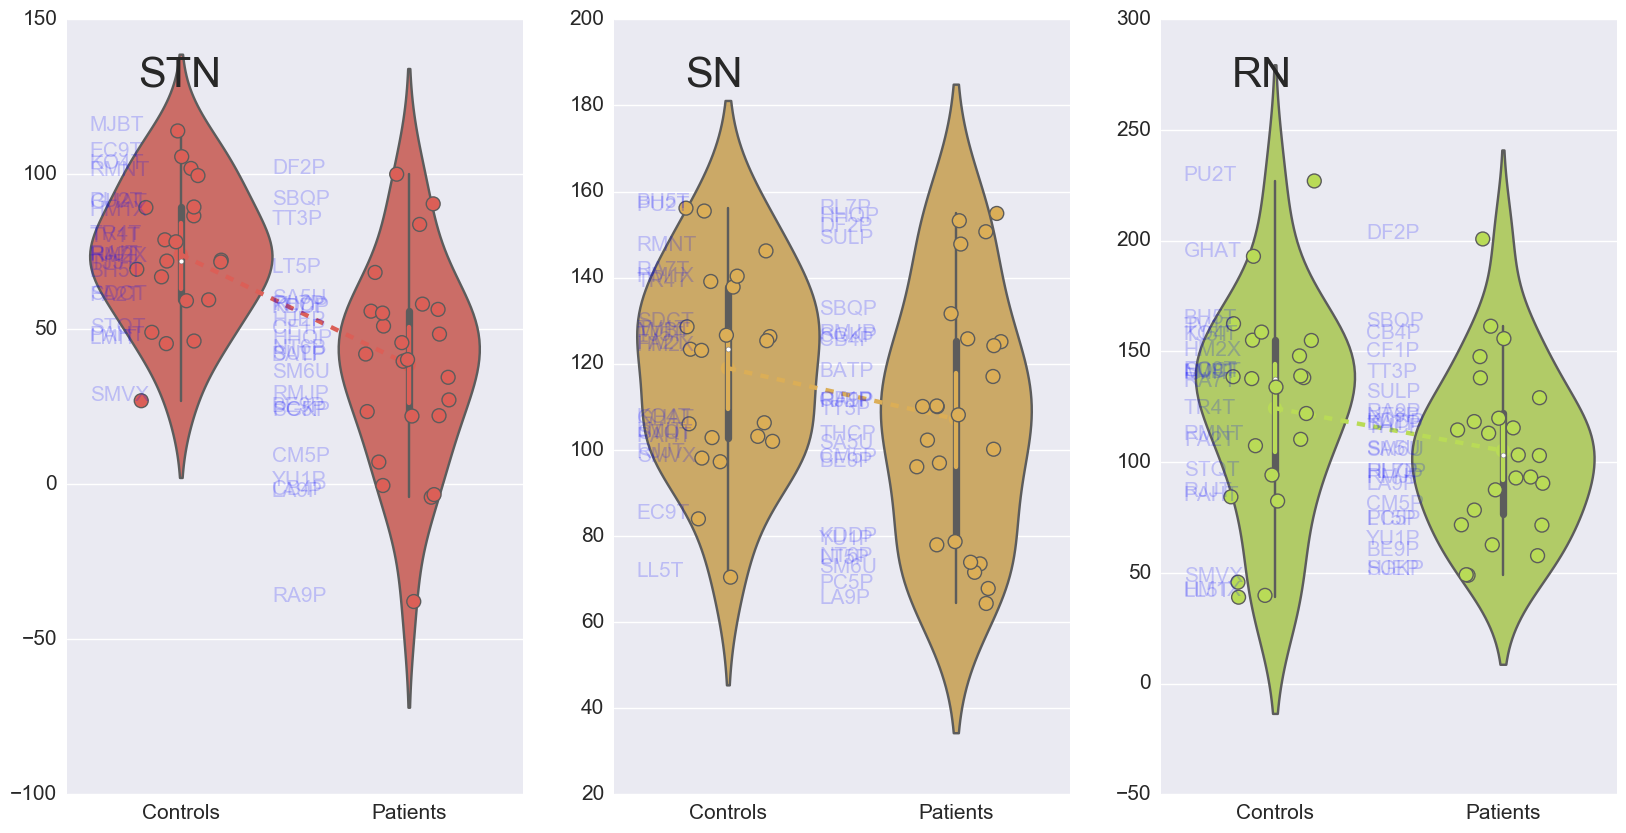

In [10]:
make_plot(controls_a,patients_a,m1 = 'STN', m2 = 'SN', m3 = 'RN')

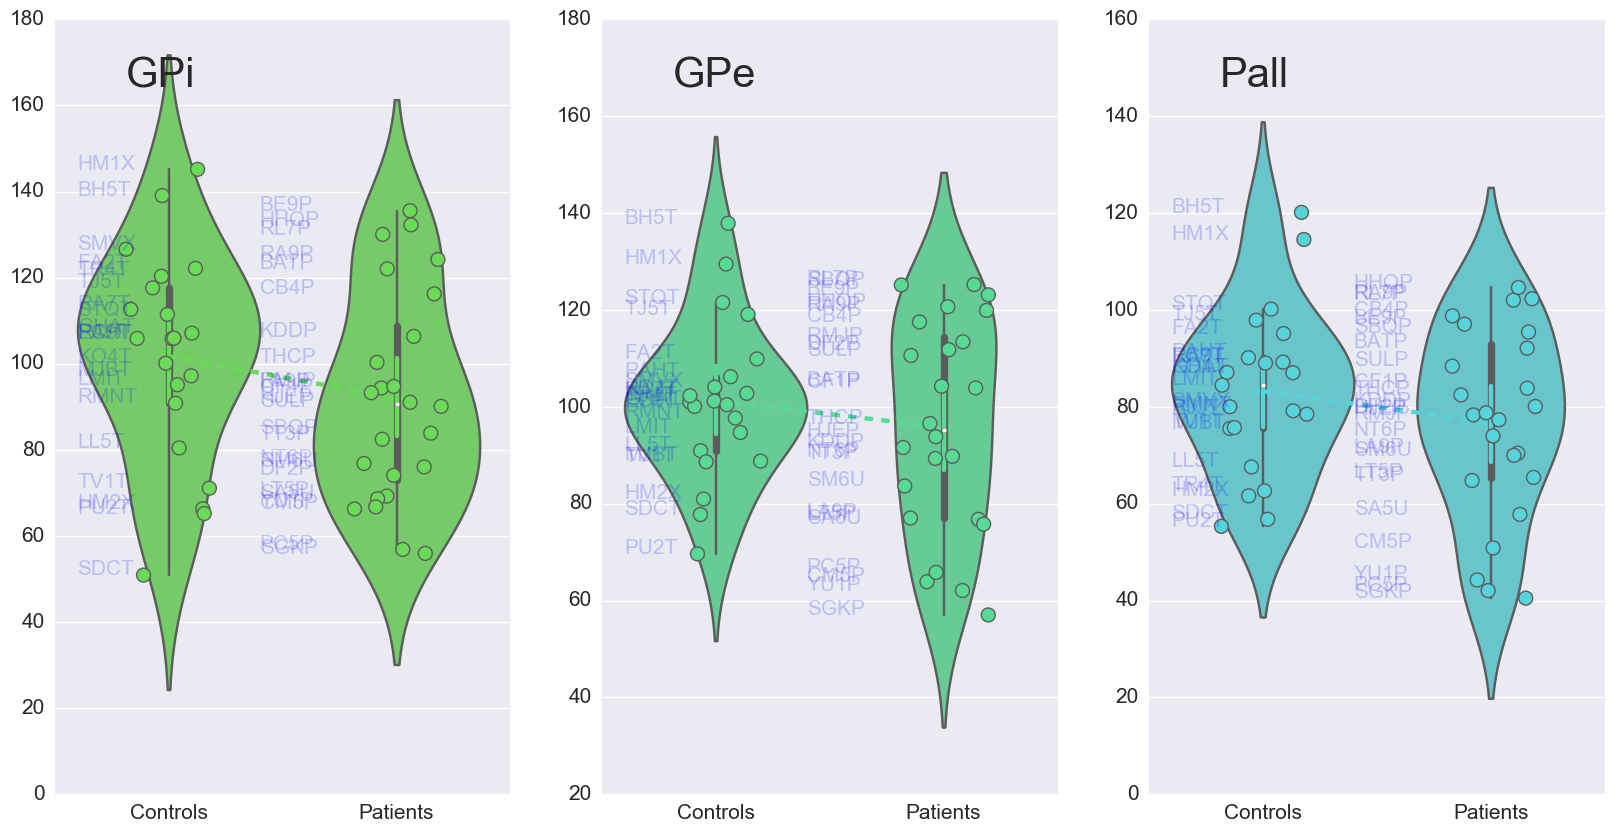

In [11]:
make_plot(controls_a,patients_a,m1 = 'GPi', m2 = 'GPe', m3 = 'Pall', pal=[3,6])

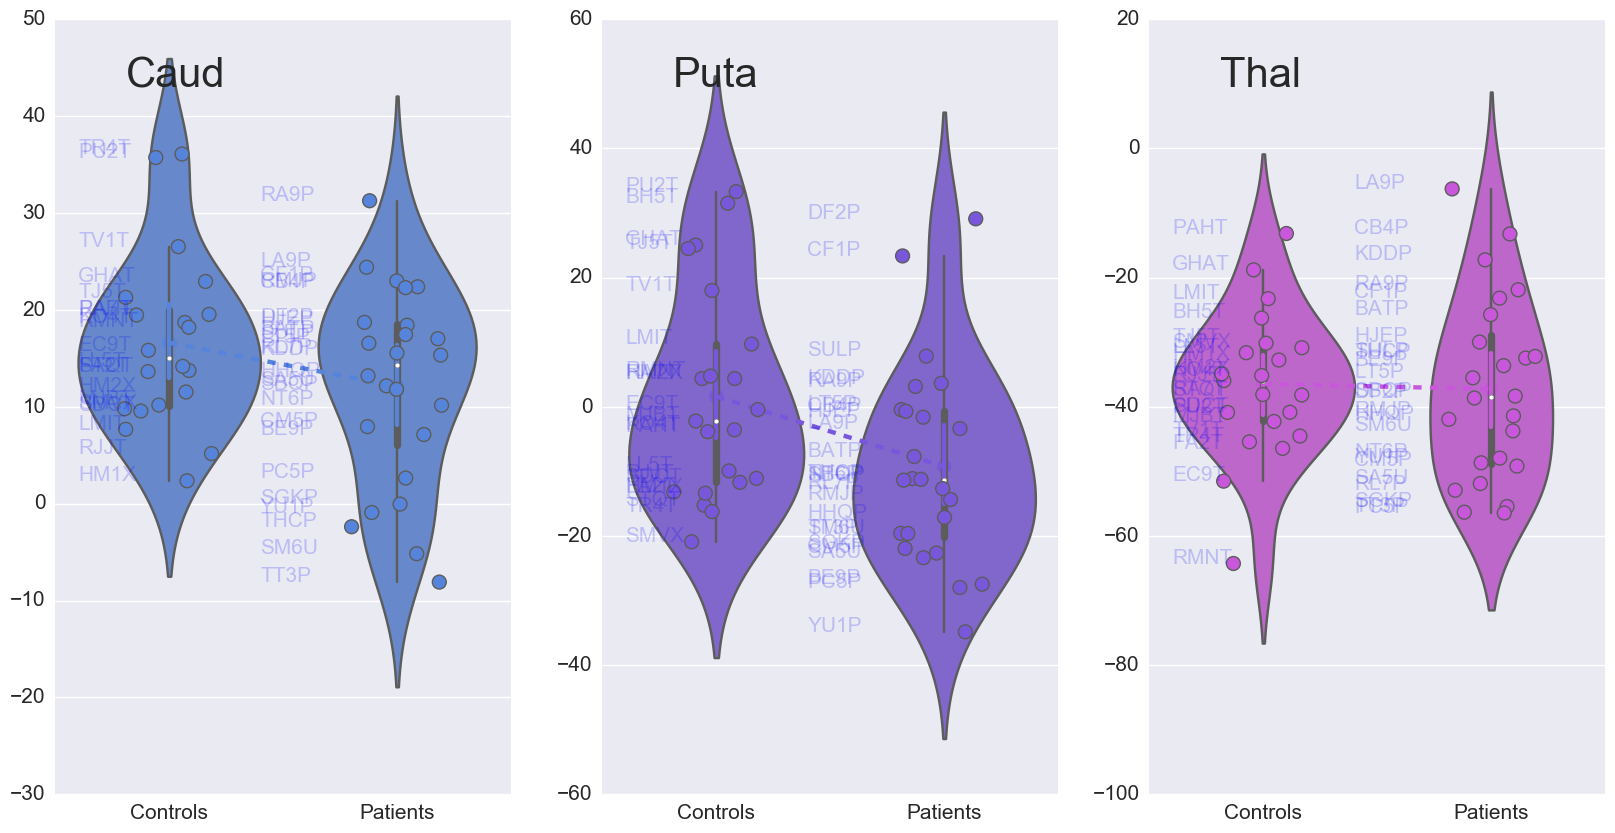

In [12]:
make_plot(controls_a,patients_a,m1 = 'Caud', m2 = 'Puta', m3 = 'Thal', pal=[6,9])

In [13]:
u = mean(patients_a.STN) + 2 * std(patients_a.STN) 
l = mean(patients_a.STN) - 2 * std(patients_a.STN)


In [14]:
def reject_outliers(data, m=3):
    return data[abs(data - np.mean(data)) < m * np.std(data)]

reject_outliers(patients_a.STN)

BE9P    0.023451
HJEP    0.051037
BATP    0.039690
LA9P   -0.004170
RMJP    0.027215
LT5P    0.068339
CM5P    0.007174
CF1P    0.048440
SM6U    0.034514
RL7P    0.056414
SGKP    0.022123
HHQP    0.045687
SA5U    0.058118
THCP    0.055841
PC5P    0.022016
SBQP    0.090461
NT6P    0.042015
TT3P    0.083821
CB4P   -0.003327
YU1P   -0.000396
RA9P   -0.037822
SULP    0.040223
KDDP    0.055232
DF2P    0.100026
Name: STN, dtype: float64

In [15]:
for measure in ['SN']:
    formula = '%s ~ Age + Gender' %measure
    p_model   = smf.ols(formula=formula, data = patients_a).fit()
    c_model   = smf.ols(formula=formula, data = controls_a).fit()
    t,p = mannwhitneyu(c_model.resid, p_model.resid)
    print measure, p 

SN 0.450210580836


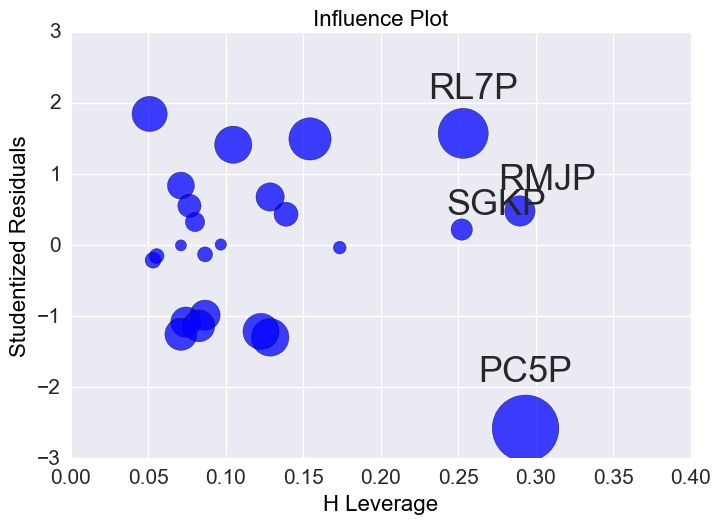

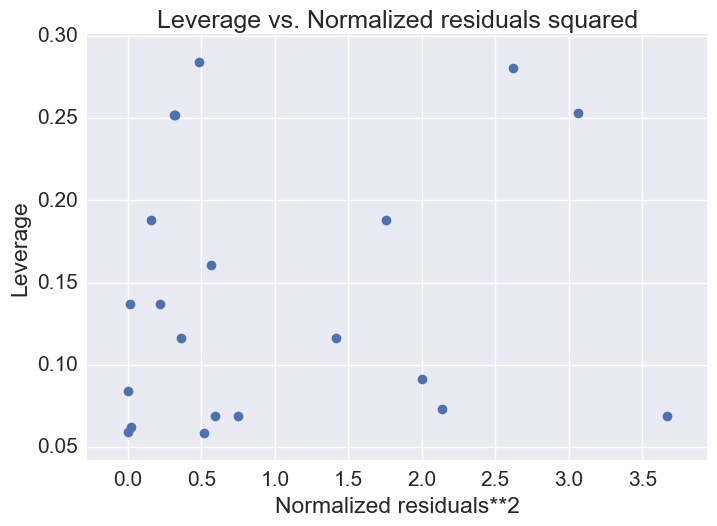

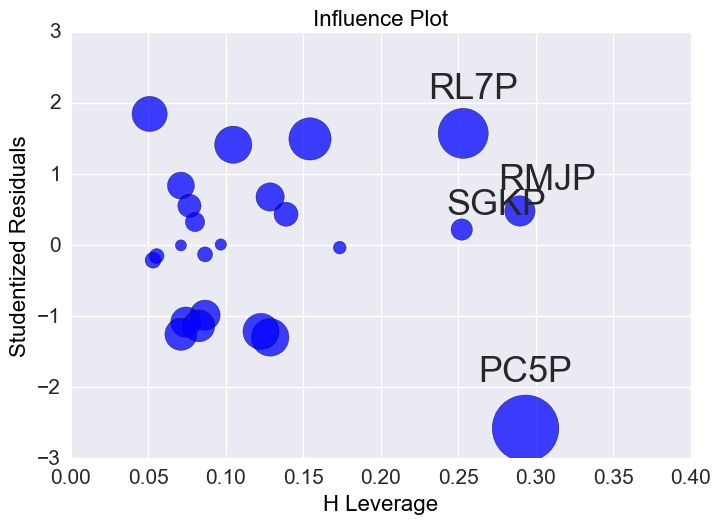

In [16]:
from statsmodels.graphics.regressionplots import *
plot_leverage_resid2(c_model)
influence_plot(p_model)

In [17]:
patients_a.sort('STN').STN

/Users/kanaan/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:1: FutureWarning: sort(columns=....) is deprecated, use sort_values(by=.....)
  if __name__ == '__main__':


RA9P   -0.037822
LA9P   -0.004170
CB4P   -0.003327
YU1P   -0.000396
CM5P    0.007174
PC5P    0.022016
SGKP    0.022123
BE9P    0.023451
RMJP    0.027215
SM6U    0.034514
BATP    0.039690
SULP    0.040223
NT6P    0.042015
HHQP    0.045687
CF1P    0.048440
HJEP    0.051037
KDDP    0.055232
THCP    0.055841
RL7P    0.056414
SA5U    0.058118
LT5P    0.068339
TT3P    0.083821
SBQP    0.090461
DF2P    0.100026
Name: STN, dtype: float64

In [18]:
higher_better = ['SNR_PHS','CNR_PHS', 'FBER_PHS',]
lower_better  = ['EFC_PHS', 'FWHM_PHS', 'QI1_PHS', 'FD']  

In [19]:
def get_lower_outlier(df, measure):
    print measure
    df = df[measure]
    cut =  np.mean(df) - 3*np.std(df)
    print 'mean=',np.mean(df), 'cut=',cut
    for s,v in zip(df.index,df):    
        if v < cut:
            print s,v
    print ''

In [20]:
get_lower_outlier(XX, 'SNR_PHS')
get_lower_outlier(XX, 'CNR_PHS')
get_lower_outlier(XX, 'FBER_PHS')

SNR_PHS
mean= 2.67105119069 cut= 1.37209332077

CNR_PHS
mean= 0.0593896071622 cut= -0.0816312537836

FBER_PHS
mean= 6.93991279618 cut= -0.377446167775



In [21]:
def get_higher_outlier(df, measure):
    print measure
    df = df[measure]
    cut =  np.mean(df) + 2*np.std(df)
    print 'mean=',np.mean(df), 'cut=',cut
    for s,v in zip(df.index,df):    
        if v > cut:
            print s,v
get_higher_outlier(XX, 'EFC_PHS')
get_higher_outlier(XX, 'FWHM_PHS')
get_higher_outlier(XX, 'QI1_PHS')
get_higher_outlier(XX, 'FD')

EFC_PHS
mean= 0.626572435093 cut= 0.687106445896
LA9P 0.7080005941
RA9P 0.6901593489
FWHM_PHS
mean= 3.67538577778 cut= 4.30576371436
BATP 4.51808
TT3P 4.32115
QI1_PHS
mean= 0.131940236116 cut= 0.188618702951
LA9P 0.2072303572
RA9P 0.2266500554
FD
mean= 0.211333819567 cut= 0.494081686475
RMJP 0.5354320051
CB4P 0.8572296358
RA9P 0.5141378981


In [22]:
get_higher_outlier(XX, 'EFC_PHS')
get_higher_outlier(XX, 'FWHM_PHS')
get_higher_outlier(XX, 'QI1_PHS')
get_higher_outlier(XX, 'FD')

EFC_PHS
mean= 0.626572435093 cut= 0.687106445896
LA9P 0.7080005941
RA9P 0.6901593489
FWHM_PHS
mean= 3.67538577778 cut= 4.30576371436
BATP 4.51808
TT3P 4.32115
QI1_PHS
mean= 0.131940236116 cut= 0.188618702951
LA9P 0.2072303572
RA9P 0.2266500554
FD
mean= 0.211333819567 cut= 0.494081686475
RMJP 0.5354320051
CB4P 0.8572296358
RA9P 0.5141378981


In [23]:
def print_outlier(df, measure):
    print measure
    df = df[measure]
    ucut =  np.mean(df) + 2*np.std(df)
    lcut =  np.mean(df) - 2*np.std(df)
    print 'mean=',np.mean(df), 'ucut=',ucut,  'lcut=',lcut
    for s,v in zip(df.index,df):    
        if v > ucut:
            print s,v
    for s,v in zip(df.index,df):    
        if v < lcut:
            print s,v        
    

In [24]:
print_outlier(patients_a,'SN')

SN
mean= 0.1071605625 ucut= 0.162662126381 lcut= 0.0516589986194


In [25]:
VV = pd.DataFrame([XX.RN,XX.CLN_Ferritin ]).T.dropna()

def get_polfit_r(X,y,d):
    coef = np.polyfit(X,y,d)
    results = {}
    results['polynomial'] = coef.tolist()
    p = np.poly1d(coef)
    yhat = p(X)
    ybar = np.sum(y)/len(y)
    ssreg = np.sum((yhat-ybar)**2)
    sstot = np.sum((y - ybar)**2)
    ssreg / sstot
    results['determination'] = ssreg / sstot
    r = np.sqrt(results['determination'])
    N = len(VV.index)
    t = r/(np.sqrt((1-r**2) / (N-2)))
    p = ss.t.sf(t,df= (N-2) ) * 2
    return r, p


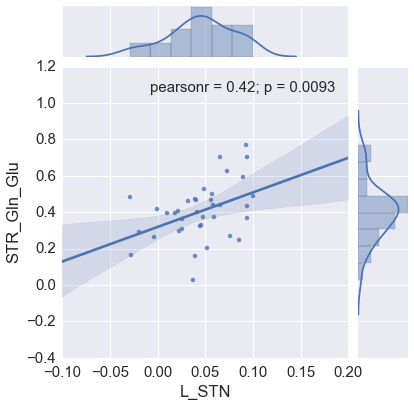

In [26]:
m1 = 'L_STN'
m2 = 'STR_Gln_Glu'
VV = pd.DataFrame([XX[m1],XX[m2] ]).T.dropna()
#VV = pd.DataFrame([controls_a[m1],controls_a[m2] ]).T.dropna()
#VV = pd.DataFrame([patients_a[m1],patients_a[m2] ]).T.dropna()
sns.jointplot(x=m1, y=m2, data=VV, kind = 'reg')

(0.45535617106271653, 0.0046265050706566745)


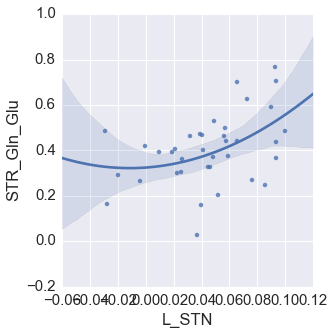

In [27]:
print get_polfit_r(X = VV[m1], y = VV[m2], d=2)
sns.lmplot(x=m1, y=m2, data=VV,order=2, truncate= 0, ci = 95)
#plt.xlim(-0.01, 0.14)

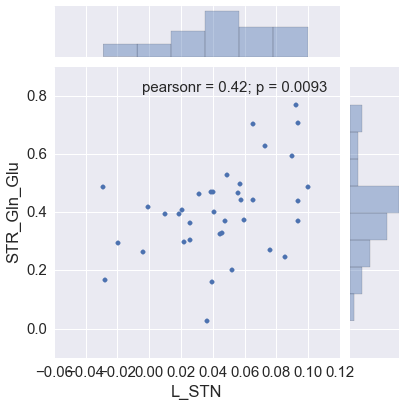

In [28]:
sns.jointplot(x=m1, y=m2, data=VV)

In [29]:
datadirx = '/Users/kanaan/SCR/Dataframes_20150820'

def get_all_dfs(img, population, study_id, trt=False):
    quant = 'median'
    QSM = pd.read_csv(os.path.join(datadir, '%s_%s_%s_%s.csv'%(img, quant, population, study_id)),index_col = 0)
    QSM['Gender']  = QSM['Gender'].map({' F': 1, ' M': 0})
    if trt is False:
        ACC = pd.read_csv(os.path.join(mrsdir, 'moco_df_%s_%s_%s.csv'%('ACC', population, study_id)),index_col = 0)
        ACC.columns = ['ACC_' + str(col) for col in ACC.columns]
        THA = pd.read_csv(os.path.join(mrsdir, 'moco_df_%s_%s_%s.csv'%('THA', population, study_id)),index_col = 0)
        THA.columns = ['THA_' + str(col) for col in THA.columns]
        twix= 'study_a/results_dir/%s/v3_absolute_%s_twix_ppmst_%s_%s_a.csv'%('STR', 'STR', '3.67',population)
        STR = pd.read_csv(os.path.join(datadirx,twix), index_col = 0)
        #STR = pd.read_csv(os.path.join(mrsdir, 'moco_df_%s_%s_%s.csv'%('STR', population, study_id)),index_col = 0)
        STR.columns = ['STR_' + str(col) for col in STR.columns]
    elif trt is True:
        ACC = pd.read_csv(os.path.join(mrsdir, 'moco_df_%s_%s_trt_%s.csv'%('ACC', population, study_id)),index_col = 0)
        ACC.columns = ['ACC_' + str(col) for col in ACC.columns]
        THA = pd.read_csv(os.path.join(mrsdir, 'moco_df_%s_%s_trt_%s.csv'%('THA', population, study_id)),index_col = 0)
        THA.columns = ['THA_' + str(col) for col in THA.columns]
        STR = pd.read_csv(os.path.join(mrsdir, 'moco_df_%s_%s_trt_%s.csv'%('STR', population, study_id)),index_col = 0)
        STR.columns = ['STR_' + str(col) for col in STR.columns]
        
        if population =='controls':
            STR.index = STR.index.map(lambda x: str(x)[:-1])
        print STR.index
    
    CLN = pd.read_csv(os.path.join(clinical_dir, 'clinical_%s_a.csv'%(population)), index_col=0)
    CLN.columns = ['CLN_' + str(col) for col in CLN.columns]    
    df = pd.concat([QSM, ACC, THA, STR, CLN], axis=1, join_axes=[QSM.index])
    return df

drop_p = ['THCP']
controls_a = get_all_dfs('QSM', 'controls', 'a')#.drop(drop_c, axis = 0) 
patients_a = get_all_dfs('QSM', 'patients', 'a').drop(drop_p, axis = 0)
controls_b = get_all_dfs('QSM', 'controls', 'b', trt=True).drop(['TR4T'], axis = 0) 
patients_b = get_all_dfs('QSM', 'patients', 'b', trt=True)#.drop(drop_p, axis = 0) 
#patients_b.STR_Gln

Index([u'BM8X', u'GF3T', u'GH4T', u'GSNT', u'HCTT', u'HR8T', u'LMIT', u'MJBT',
       u'PAHT', u'RJJT', u'RMNT', u'SDCT', u'SJBT', u'STQT', u'TJ5T', u'TR4T',
       u'TSCT', u'ZT5T'],
      dtype='object')
Index([u'CM5P', u'FL3P', u'FMEP', u'HJEP', u'HRPP', u'KDDP', u'LA9P', u'LT5P',
       u'SULP', u'TSEP', u'WO2P'],
      dtype='object')


In [30]:
controls_b.index = controls_b.index + 'b'
patients_b.index = patients_b.index + 'b'

(-0.1, 0.2)

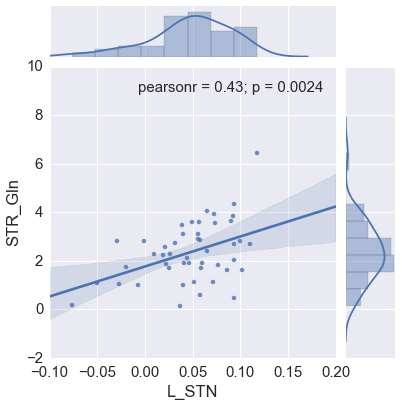

In [31]:
alldfs = [controls_a, patients_a]
AA = df = pd.concat(alldfs, axis=0)
m1 = 'L_STN'
m2 = 'STR_Gln'
VV = pd.DataFrame([AA[m1] , AA[m2]] ).T.dropna()
sns.jointplot(x=m1, y=m2, data=VV.drop([], axis = 0), kind = 'reg')
#VV.sort(m1)
#len(VV.index)
plt.xlim(-0.1, 0.2)

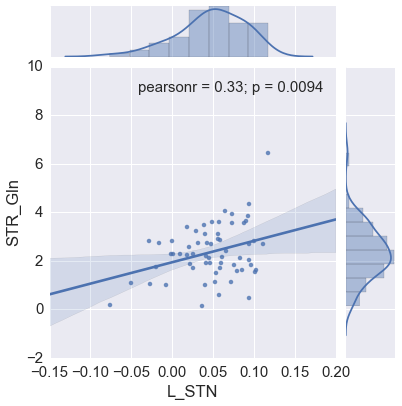

In [32]:
alldfs = [patients_a, controls_a , patients_b, controls_b]
AA = df = pd.concat(alldfs, axis=0)
m1 = 'L_STN'
m2 = 'STR_Gln'
VV = pd.DataFrame([AA[m1] , AA[m2]] ).T.dropna()
sns.jointplot(x=m1, y=m2, data=VV.drop([], axis = 0), kind = 'reg')
#VV.sort(m1)
#len(VV.index)


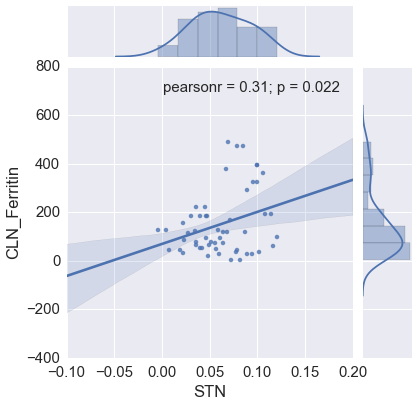

In [33]:
m1 = 'STN'
m2 = 'CLN_Ferritin'
VV = pd.DataFrame([AA[m1] , AA[m2]] ).T.dropna()
sns.jointplot(x=m1, y=m2, data=VV.drop(['SA5U','FL3Pb'], axis = 0), kind = 'reg')
#VV.sort(m2)
#len(VV.index)

(0.35739741608098025, 0.0043483271747672856)


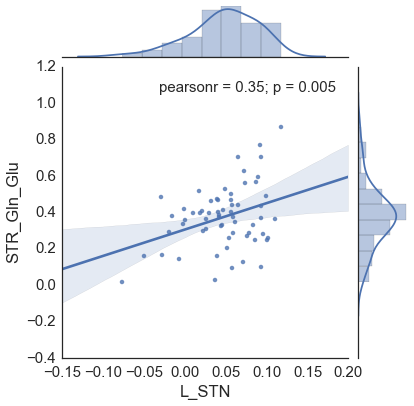

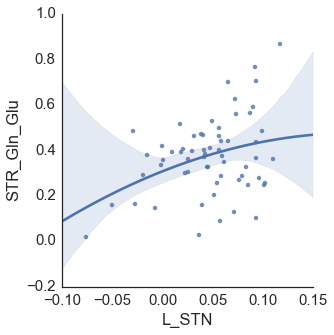

In [34]:
sns.set_style('white')
m1 = 'L_STN'
m2 = 'STR_Gln_Glu'
glglx = pd.Series(AA.STR_Gln / AA.STR_Glu, name = 'STR_Gln_Glu') 
VV = pd.DataFrame([AA[m1] , glglx]).T.dropna()
VV
sns.jointplot(x=m1, y='STR_Gln_Glu', data=VV.drop([], axis = 0), kind = 'reg')
print get_polfit_r(X = VV[m1], y = VV[m2], d=2)
sns.lmplot(x=m1, y=m2, data=VV,order=2, truncate= 0, ci = 95)

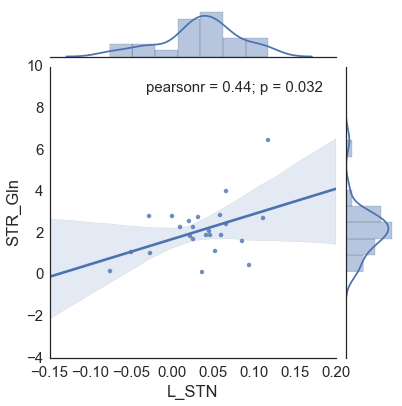

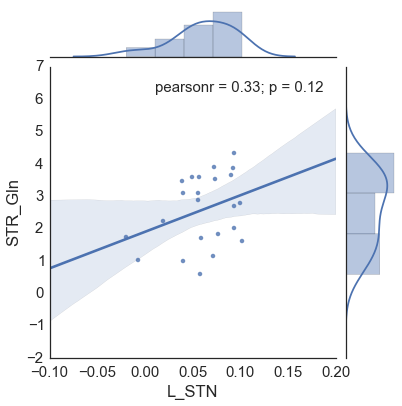

In [35]:
sns.jointplot(x=patients_a.L_STN, y=patients_a.STR_Gln, kind = 'reg')
sns.jointplot(x=controls_a.L_STN, y=controls_a.STR_Gln, kind = 'reg')

(0.35739741608098025, 0.0043483271747672856)


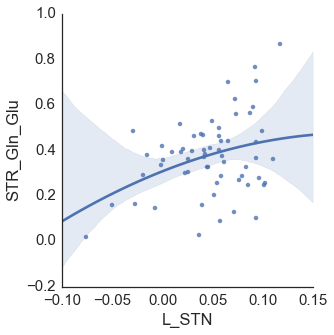

In [36]:
print get_polfit_r(X = VV[m1], y = VV[m2], d=2)
sns.lmplot(x=m1, y=m2, data=VV,order=2, truncate= 0, ci = 95)
#plt.xlim(-0.01, 0.14)

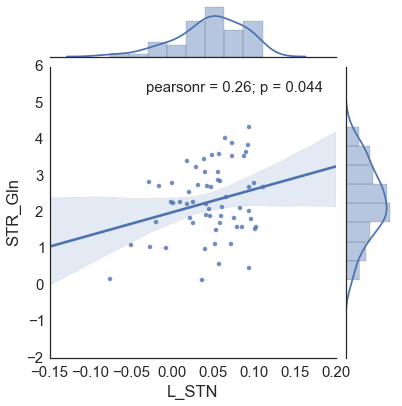

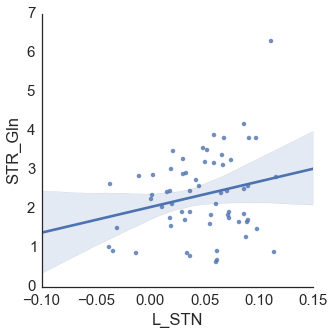

In [37]:
m1 = 'L_STN'
m2 = 'STR_Gln'
m3 = 'FD'
VV = pd.DataFrame([AA[m1] , AA[m2], AA[m3]] ).T.dropna()
sns.jointplot(x=m1, y=m2, data=VV.drop(['STDP'], axis = 0), kind = 'reg')
#VV.sort('STR_Gln')
#len(VV.index)
sns.lmplot(x = m1, y = m2, data = VV, x_partial = 'FD', y_partial = 'FD') 

In [38]:
def plot_partial_correlation(data, x, y, xlim, ylim, regressors = None, color = None, annotate = None, fig_name = None, 
                             dpi = 100, labels = True, jitter = None,fit_reg=True, scatter=1,
                             plot_marg = 1):
    
    regressors_columns = [data[regressor] for regressor in regressors]
    df_reg = pd.concat(regressors_columns, axis = 1).dropna(axis=0) 
    df = pd.concat([df_reg, data[x], data[y]], axis=1).dropna()
    
    # inititlize grid and plot regression and margins 
    grid = sns.JointGrid(x, y, data=df,xlim=xlim, ylim=ylim)#, size=size, ratio=ratio, space=space, #) 
    
    if plot_marg:
        grid.plot_marginals(sns.distplot, color = color, hist=False, kde = True, rug = 0, kde_kws={'shade':True})  
    
    grid.plot_joint(sns.regplot, fit_reg=fit_reg, scatter= scatter, color = color, x_partial = df[regressors], y_jitter = jitter)
    if labels:
        grid.set_axis_labels(x, y, fontsize= 15, weight='bold', color='blue', labelpad=10)
    else:
        grid.set_axis_labels(None,None)
        
    ## calculate regression parameters 
    
    formula = [ '%s ~ %s'%(y,x) + ' + %s'%regressor for regressor in regressors][0]
    model   = smf.ols(formula=formula, data= df)
    result = model.fit() 
    p_val  = np.round(result.pvalues[1], 3)
    pcor   = math.copysign(np.round(np.sqrt(result.rsquared), 3) , result.params[1])
    
    if annotate:
        plt.annotate('R=%s, P=%s' %(pcor, p_val), xy = annotate, fontsize = 13,  color='r')
                      
    if fig_name:
        plt.savefig(os.path.join(save_fig_dir, fig_name), dpi = dpi, bbox_inches='tight', transparent = True)



In [39]:
m1 = 'L_STN'
m2 = 'STR_Glx'
m3 = 'Age'
m4 = 'FD'
VV = pd.DataFrame([AA[m1] , AA[m2], AA[m3],AA[m4]] ).T.dropna()


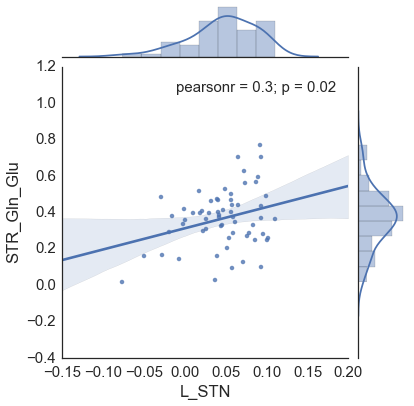

In [40]:
m1 = 'L_STN'
m2 = 'STR_Gln_Glu'
glglx = pd.Series(AA.STR_Gln / AA.STR_Glu, name = 'STR_Gln_Glu') 
VV = pd.DataFrame([AA[m1] , glglx]).T.dropna()
VV
sns.jointplot(x=m1, y='STR_Gln_Glu', data=VV.drop(['STDP'], axis = 0), kind = 'reg')


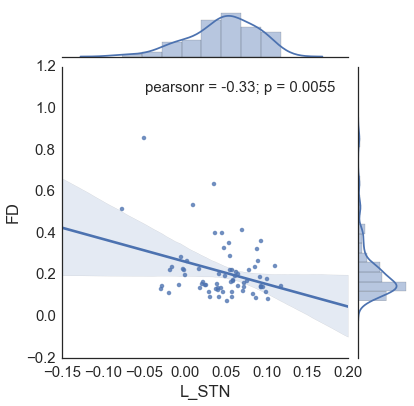

In [41]:
m1 = 'L_STN'
m2 = 'FD'
VV = pd.DataFrame([AA[m1] , AA[m2]] ).T.dropna()
sns.jointplot(x=m1, y=m2, data=VV.drop([], axis = 0), kind = 'reg')


In [42]:
np.mean(patients_a.SN) * 1000

114.96329629629631

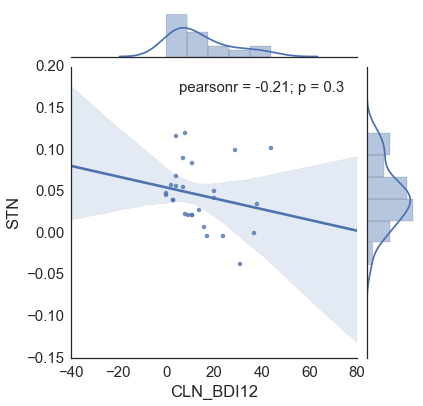

In [43]:
sns.jointplot(x = 'CLN_BDI12', y='STN',data=patients_a, kind = 'reg')

In [44]:
def return_correlation_tables(data, regressors, metabolites, clinical_measures):
    
    print 'Bonferroni threshold =',  0.05/ (len(clinical_measures) * len(metabolites) )
    
    regressors_columns = [data[regressor] for regressor in regressors]
    df_reg = pd.concat(regressors_columns, axis = 1).dropna(axis=0) 
    
    def make_multiple_reg(data, x, y):
        
        df = pd.concat([df_reg, data[x], data[y]], axis=1)
        formula = [ '%s ~ %s'%(y,x) + ' + %s'%regressor for regressor in regressors][0]
        model   = smf.ols(formula=formula, data= df)
        result = model.fit() 
        p_val  = np.round(result.pvalues[1], 3)
        pcor   = math.copysign(np.round(np.sqrt(result.rsquared), 3) , result.params[1])
        
        if p_val < 0.05:
            print x, y, 'P_val=', p_val, 'R =', pcor
        return pcor, p_val
    
    stats_df = pd.DataFrame(index = clinical_measures,  columns=metabolites)   
    
    for clinical in clinical_measures:
        for metabolite in metabolites:
            p_cor, p_val = make_multiple_reg(data,  clinical, metabolite )
            stats_df.loc['%s'%clinical][metabolite] = np.round(p_val,3)
    return stats_df


def make_fdr(df):
    fdr = pd.DataFrame()
    for i in df.index:
        for c in df.columns:
            fdr.ix['%s_%s'%(i,c),'p'] = df.loc[i][c]

    fdr = fdr.sort('p')
    
    n_comparisons = len(fdr.index)
    for i, corr in enumerate(fdr.index):
        fdr.ix[corr, 'FDR_threshold'] = np.round((0.05 * (i + 1.) / n_comparisons), 3)
        
    return fdr


In [45]:
clinical = ['CLN_RVTRS', 
'CLN_puts', 
'CLN_YBOCS_Totalscore_Items_1to10', 
#'CLN_OCIR_total score', 
#'CLN_CAARS_Score_ADHS_Symptoms_Total_Cat_G_T_Score', 
#'CLN_DSM4_clinically_significant_ADHD', 
#'CLN_qol_scale', 
#'CLN_qol_score', 
#'CLN_BDI12'
           ]
        
        
return_correlation_tables(patients_a, ['FD', 'Age', 'Gender'], measures, clinical)


Bonferroni threshold = 0.00208333333333
CLN_RVTRS Caud P_val= 0.025 R = 0.569
CLN_YBOCS_Totalscore_Items_1to10 Caud P_val= 0.013 R = 0.6
CLN_YBOCS_Totalscore_Items_1to10 Thal P_val= 0.015 R = 0.553


,Puta,Caud,Thal,SN,STN,RN,GPi,GPe
CLN_RVTRS,0.501,0.025,0.415,1,0.455,0.33,0.793,0.521
CLN_puts,0.562,0.649,0.93,0.734,0.156,0.939,0.851,0.661
CLN_YBOCS_Totalscore_Items_1to10,0.06,0.013,0.015,0.506,0.759,0.457,0.258,0.343


In [46]:
m1 = 'Caud'
m2 = 'CLN_RVTRS'
m3 = 'Age'
m4 = 'FD'
m5 = 'Gender'
VV = pd.DataFrame([AA[m1] , AA[m2], AA[m3],AA[m4], AA[m5]] ).T.dropna()


In [47]:
alldfs = [controls_a, patients_a]
AA = df = pd.concat(alldfs, axis=0)
plot_partial_correlation(patients_a, 'CLN_RVTRS', 'Caud',   regressors = [ 'Gender', 'Age'], 
                         color = None, annotate = (0, 0), fig_name = None, dpi = 100)

TypeError: plot_partial_correlation() takes at least 5 arguments (8 given)

In [ ]:
save_fig_dir='/Users/kanaan/Desktop/'
AA = pd.concat(axis=0, objs=[controls_a])
AA['STR_Gln_Glu'] = (AA['STR_Gln'] / AA['STR_Glu'])*1
plot_partial_correlation(AA, 'STR_Gln_Glu', 'L_STN',   regressors = ['Age', 'Gender'], 
                        color = 'b', annotate = (-0.3, .17), fig_name = 'c.png', dpi = 300, fit_reg=0,
                        xlim=(-0.4,1.2), ylim=(-0.125,0.2))

AA = pd.concat(axis=0, objs=[patients_a])
AA['STR_Gln_Glu'] = (AA['STR_Gln'] / AA['STR_Glu'])*1
plot_partial_correlation(AA, 'STR_Gln_Glu', 'L_STN',   regressors = ['Age', 'Gender'], 
                        color = 'r', annotate = (-0.3, .15), fig_name = 'p.png', dpi = 300, fit_reg=0,
                        xlim=(-0.4,1.2), ylim=(-0.125,0.2))


AA = pd.concat(axis=0, objs=[controls_a, patients_a])
AA['STR_Gln_Glu'] = (AA['STR_Gln'] / AA['STR_Glu'])*1
plot_partial_correlation(AA, 'STR_Gln_Glu', 'L_STN',   regressors = ['Age','Gender'], 
                        color = 'g', annotate = (-0.3, .13), fig_name = 'all.png', dpi = 300, fit_reg=1,
                        xlim=(-0.4,1.2), ylim=(-0.125,0.2), scatter=0,plot_marg=0)

In [ ]:
save_fig_dir='/Users/kanaan/Desktop/'
XvX = 'STR_Gln'
xlim = (-1,8)
ylim = (-0.125,0.2)
dpi = 300 
AA = pd.concat(axis=0, objs=[controls_a])
plot_partial_correlation(AA, XvX, 'L_STN',   regressors = ['Age', 'Gender'], 
                        color = 'b', annotate = (-0.3, .17), fig_name = 'c2.png', dpi = dpi, fit_reg=0,
                        xlim=xlim, ylim=ylim)

AA = pd.concat(axis=0, objs=[patients_a])
plot_partial_correlation(AA, XvX, 'L_STN',   regressors = ['Age', 'Gender'], 
                        color = 'r', annotate = (-0.3, .15), fig_name = 'p2.png', dpi = dpi, fit_reg=0,
                        xlim=xlim, ylim=ylim)


AA = pd.concat(axis=0, objs=[controls_a, patients_a])
plot_partial_correlation(AA, XvX, 'L_STN',   regressors = ['Age','Gender'], 
                        color = 'g', annotate = (-0.3, .13), fig_name = 'all2.png', dpi = dpi, fit_reg=1,
                        xlim=xlim, ylim=ylim, scatter=0,plot_marg=0)

In [ ]:
save_fig_dir='/Users/kanaan/Desktop/'
XvX = 'STR_Gln'
xlim = (-1,8)
ylim = (-0.125,0.2)
dpi = 300 
AA = pd.concat(axis=0, objs=[controls_a])
plot_partial_correlation(AA, XvX, 'L_STN',   regressors = ['Age', 'Gender'], 
                        color = 'b', annotate = (-0.3, .17), fig_name = 'c2.png', dpi = dpi, fit_reg=0,
                        xlim=xlim, ylim=ylim)

AA = pd.concat(axis=0, objs=[patients_a])
plot_partial_correlation(AA, XvX, 'L_STN',   regressors = ['Age', 'Gender'], 
                        color = 'r', annotate = (-0.3, .15), fig_name = 'p2.png', dpi = dpi, fit_reg=0,
                        xlim=xlim, ylim=ylim)


AA = pd.concat(axis=0, objs=[controls_a, patients_a])
plot_partial_correlation(AA, XvX, 'L_STN',   regressors = ['Age','Gender'], 
                        color = 'g', annotate = (-0.3, .13), fig_name = 'all2.png', dpi = dpi, fit_reg=1,
                        xlim=xlim, ylim=ylim, scatter=0,plot_marg=0)

In [ ]:
AA = pd.concat(axis=0, objs=[controls_a, patients_a]).drop(['STDP'],axis=0)
df = controls_a
df2=patients_a.drop(['STDP'],axis=0)
x= 'L_STN'
y='STR_Gln'
c1 = 'b'
c2 ='r'
regressors = ['Age','Gender', 'FD']

fig, ax = plt.subplots(1)
fig.set_size_inches([5,5])

sns.regplot(x=x,y=y,data=AA,  color='g', fit_reg=1)
sns.regplot(x=x,y=y,data=df1, color='b', fit_reg=0)
sns.regplot(x=x,y=y,data=df2, color='r', fit_reg=0)


#grid.plot_joint(sns.regplot, color = c1)


In [ ]:

c2 = 'blue'
linestyle =['--']
scale = 2
marker = '.'
g = sns.pointplot(data=data_2a, color = c1, linestyles=linestyle, markers=['.'], scale= scale)
g = sns.pointplot(data=data_2b, color = c1, linestyles=linestyle, markers=['.'], scale= scale)
g = sns.pointplot(data=data_2c, color = c1, linestyles=linestyle, markers=['.'], scale= scale)
g = sns.pointplot(data=data_3a, color = c2, linestyles=linestyle, markers=['.'], scale= scale)
g = sns.pointplot(data=data_3b, color = c2, linestyles=linestyle, markers=['.'], scale= scale)
g = sns.pointplot(data=data_3c, color = c2, linestyles=linestyle, markers=['.'], scale= scale)

g.set_xticks([])
g.set_yticks([0, 2,4,6,8,10,12,14])
ax.legend(frameon=False)
sns.despine(left=True, bottom=True)
ax.tick_params(axis='y', labelsize=fontsize)
plt.ylim(-2, 16)
plt.xlim(-0.7,8.5)

plt.savefig('/Users/kanaan/Desktop/Glu_Paper/Figures_python/fig3_plt_scatter_tha_367_strip.png', dpi = 500, bbox_inches='tight', transparent = True)

In [ ]:
sns.regplot?

In [ ]:
patients_a.STR_Gln

In [ ]:
sns.JointGrid?

In [81]:
import numpy as np
from scipy import stats, linalg

def partial_corr(C):
    """
    Returns the sample linear partial correlation coefficients between pairs of variables in C, controlling 
    for the remaining variables in C.
    Parameters
    ----------
    C : array-like, shape (n, p)
        Array with the different variables. Each column of C is taken as a variable
    Returns
    -------
    P : array-like, shape (p, p)
        P[i, j] contains the partial correlation of C[:, i] and C[:, j] controlling
        for the remaining variables in C.
    """
    
    C = np.asarray(C)
    p = C.shape[1]
    P_corr = np.zeros((p, p), dtype=np.float)
    for i in range(p):
        P_corr[i, i] = 1
        for j in range(i+1, p):
            idx = np.ones(p, dtype=np.bool)
            idx[i] = False
            idx[j] = False
            beta_i = linalg.lstsq(C[:, idx], C[:, j])[0]
            beta_j = linalg.lstsq(C[:, idx], C[:, i])[0]

            res_j = C[:, j] - C[:, idx].dot( beta_i)
            res_i = C[:, i] - C[:, idx].dot(beta_j)
            
            corr = stats.pearsonr(res_i, res_j)[0]
            P_corr[i, j] = corr
            P_corr[j, i] = corr
        
    return P_corr

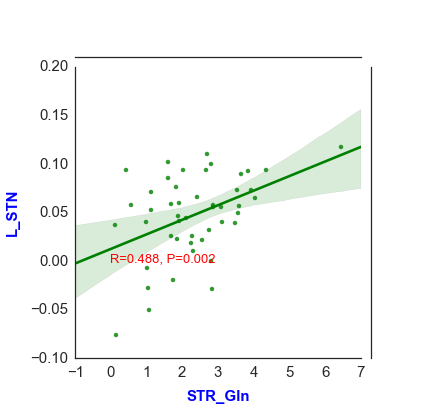

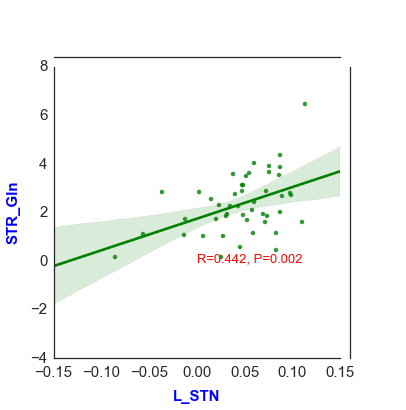

In [82]:
alldfs = [patients_a, controls_a]
AA = df = pd.concat(alldfs, axis=0)
m1 = 'L_STN'
m2 = 'STR_Gln'
m3 = 'Age'
VV = pd.DataFrame([AA[m1] , AA[m2], AA[m3]] ).T.dropna()
#sns.jointplot(x=m1, y=m2, data=VV.drop([], axis = 0), kind = 'reg')

plot_partial_correlation(VV, m2, m1,   regressors = [m3], 
                        color = 'g', annotate = (0, 0), fig_name = None, dpi = 10, fit_reg=1,
                        xlim=None, ylim=None, scatter=1,plot_marg=0)

plot_partial_correlation(VV, m1, m2,   regressors = [m3], 
                        color = 'g', annotate = (0, 0), fig_name = None, dpi = 10, fit_reg=1,
                        xlim=None, ylim=None, scatter=1,plot_marg=0)

In [83]:
partial_corr(VV)

array([[ 1.        ,  0.43806591,  0.25173155],
       [ 0.43806591,  1.        ,  0.47901161],
       [ 0.25173155,  0.47901161,  1.        ]])